In [1]:
#import our basic data manipulation modules
import pandas as pd
import numpy as np
import scipy

#import our basic visualization modules
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#turn off warnings for sns depreciated versions- this is the best
import warnings
warnings.filterwarnings('ignore')

#import modules that describe distributions
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew

In [2]:
df = pd.read_csv("Dunder Mifflin Fundraising.csv")
df.head()

,Lookup,Hour,Days since last checkin,Check Ins,Contacts Created,Images Uploaded,Notes Written,Checkin_w_images,Checkin_w_Contact,Checkin_w_Note,...,LocRegion,LocProvince,Distance,FundraisingYear,day of week,day of month,Past 1-3 avg,Past 3-6 avg,Change in past week,target
0,30207-5-3-2017,10,30,1,2,1,0,1,1,0,...,BA,CA,3052.102363,2017,4,3,0.000000,0.000000,0.000000,0
1,30207-5-6-2017,16,3,1,0,3,0,1,0,0,...,BA,CA,3052.102363,2017,7,6,0.000000,0.000000,0.000000,0
2,30207-5-7-2017,10,1,0,0,0,1,0,0,0,...,BA,CA,3052.102363,2017,1,7,0.000000,0.000000,0.000000,0
3,30207-5-7-2018,11,30,1,0,0,0,0,0,0,...,BA,CA,3052.102363,2018,2,7,0.000000,0.000000,0.000000,0
4,30207-5-15-2018,20,8,1,0,0,0,0,0,0,...,BA,CA,3052.102363,2018,3,15,1078.333333,881.333333,0.223525,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 28 columns):
Lookup                     1914 non-null object
Hour                       1914 non-null int64
Days since last checkin    1914 non-null int64
Check Ins                  1914 non-null int64
Contacts Created           1914 non-null int64
Images Uploaded            1914 non-null int64
Notes Written              1914 non-null int64
Checkin_w_images           1914 non-null int64
Checkin_w_Contact          1914 non-null int64
Checkin_w_Note             1914 non-null int64
Checkin_w_I_C              1914 non-null int64
Checkin_w_C_N              1914 non-null int64
Checkin_w_I_N              1914 non-null int64
Checkin_w_All              1914 non-null int64
Property Type              1914 non-null object
RegionName                 1914 non-null object
PopulationRank             1914 non-null int64
Market                     1914 non-null object
LocRegion                  1914 non-null ob

In [4]:
df = df.drop(['LocProvince','Market','RegionName'],axis=1)
df[['Hour','PopulationRank','FundraisingYear','day of week']] = df[['Hour','PopulationRank','FundraisingYear','day of week']].astype('category')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 25 columns):
Lookup                     1914 non-null object
Hour                       1914 non-null category
Days since last checkin    1914 non-null int64
Check Ins                  1914 non-null int64
Contacts Created           1914 non-null int64
Images Uploaded            1914 non-null int64
Notes Written              1914 non-null int64
Checkin_w_images           1914 non-null int64
Checkin_w_Contact          1914 non-null int64
Checkin_w_Note             1914 non-null int64
Checkin_w_I_C              1914 non-null int64
Checkin_w_C_N              1914 non-null int64
Checkin_w_I_N              1914 non-null int64
Checkin_w_All              1914 non-null int64
Property Type              1914 non-null object
PopulationRank             1914 non-null category
LocRegion                  1914 non-null object
Distance                   1914 non-null float64
FundraisingYear            1914 non-

In [6]:
df = pd.get_dummies(data=df,
                    columns=['Hour','Property Type','PopulationRank','LocRegion','FundraisingYear','day of week'])

In [7]:
#Create a list that displays only numeric variables
numeric_var=df.select_dtypes(include=[np.number]).columns
#Here we set up our correlation matrix for numeric variables
correlation=df[numeric_var].corr()
#Pull the max (whether positive or negative) correlation of each variable to another variable
aux=(abs(correlation)-np.identity(correlation.shape[0])).max()

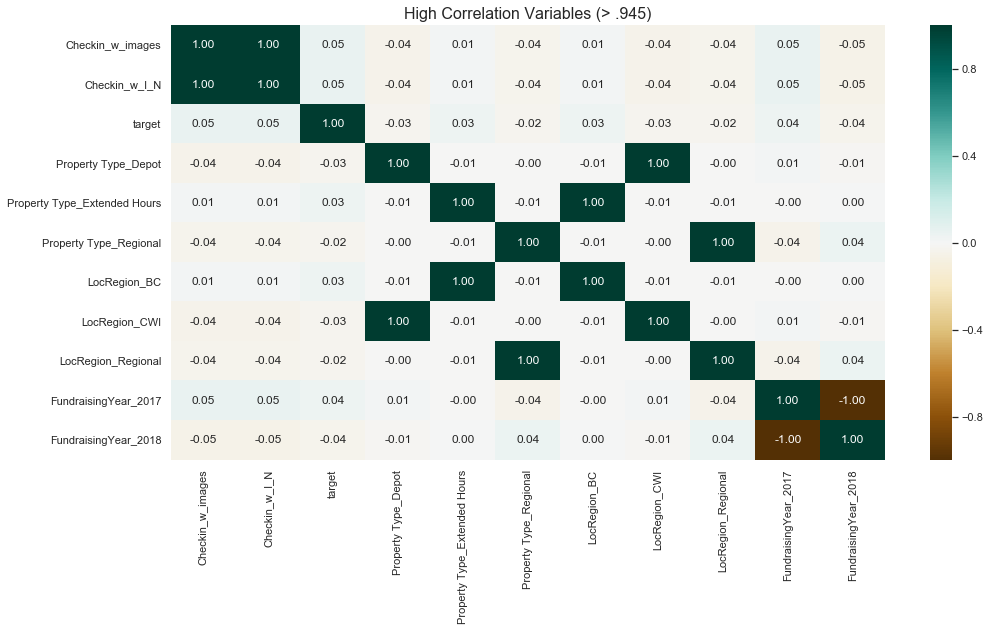

In [8]:
#Throw out any variables that don't have at least .7 correlation with something else or isn't Target
selected_feats=aux[(aux>0.90) | ((aux>0.182724) & (aux<0.182726))].index
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
#make the plot have numbers, a legend and pretty colors
sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax,cmap="BrBG",center=0)
plt.title('High Correlation Variables (> .945)',fontsize=16)
#show the plot
plt.show()

In [9]:
df = df.drop(['Checkin_w_I_N','LocRegion_BC','LocRegion_CWI','LocRegion_Regional','FundraisingYear_2017'],axis=1)

## Modeling

In [10]:
#Import the models we will be using
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler

#Bring in our crossvalidations
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, KFold

#Import the modules we will use to score our models
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, accuracy_score, mean_squared_error, log_loss
import itertools
from sklearn.model_selection import learning_curve, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score

In [11]:
#Retain our id fields
Id = df['Lookup']
#Create the two new data frames
train_y = pd.DataFrame()
train_x = pd.DataFrame()
#save our Target as our y variable
train_y['target'] = df['target']
train_x = df.drop(['target','Lookup'],axis=1)

In [12]:
#perform the train & test split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3501, random_state=13)

In [13]:
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [14]:
F1_scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

In [15]:
#Create a variable that will show us the best parameters, with what accuracy it predicts and what the F1 score is for its predictions
def show_me_the_money(model,test_y,test_x):
    #print("Best Params: {}".format(model.best_params_))
    print("Test Accuracy: {}".format(accuracy_score(test_y, model.predict(test_x))))
    print("F1 Score: {}".format(f1_score(test_y, model.predict(test_x),average='macro')))
    
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    
    train_auc = roc_auc_score(y_train, train_predictions)
    test_auc = roc_auc_score(y_test, test_predictions)

    print("Train MSE: {}".format(train_mse))
    print("Test MSE: {}".format(test_mse))
    
    print("Train ROC AUC: {}".format(train_auc))
    print("Test ROC AUC: {}".format(test_auc))
    
    

In [16]:
#generalized confusion matrix plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize = (8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted label', size = 16)

    
#specific matrix for our needs    
def show_con_matrix(model,test_y,test_x,title):
    pred_matrix = confusion_matrix(test_y, model.predict(test_x))
    plot_confusion_matrix(pred_matrix, classes = ['Less effective', 'More effective'],
                      title = title)
    plt.show

In [17]:
## source: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=F1_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Support Vector Classification

In [18]:
#set up model, allow it to use all cores
svc = svm.SVC(class_weight='balanced',probability=True)

#set hyperparameters
param_grid = {"C": [.001,.01,1,10,100,1000],
              "gamma":['auto','scale']}

#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
svc_gridsearch = GridSearchCV(svc,param_grid=param_grid,scoring=F1_scorer,cv=10)

#fit model
svc_gridsearch.fit(X_train,y_train)

#save model
optimised_svc = svc_gridsearch.best_estimator_
optimised_svc

C:\Users\zgeorge\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
#see how it did
show_me_the_money(optimised_svc,y_test,X_test)

Test Accuracy: 0.7093889716840537
F1 Score: 0.6224430613145889
Train MSE: 0.07642799678197908
Test MSE: 0.2906110283159464
Train ROC AUC: 0.9482163492004323
Test ROC AUC: 0.6350150037509378


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

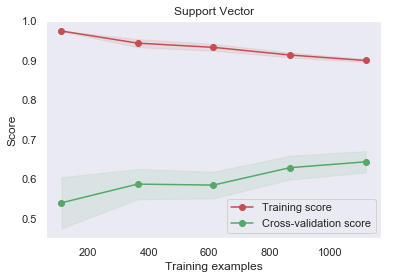

In [20]:
plot_learning_curve(optimised_svc,'Support Vector',X_train,y_train,cv=10,n_jobs=-1)

Confusion matrix, without normalization


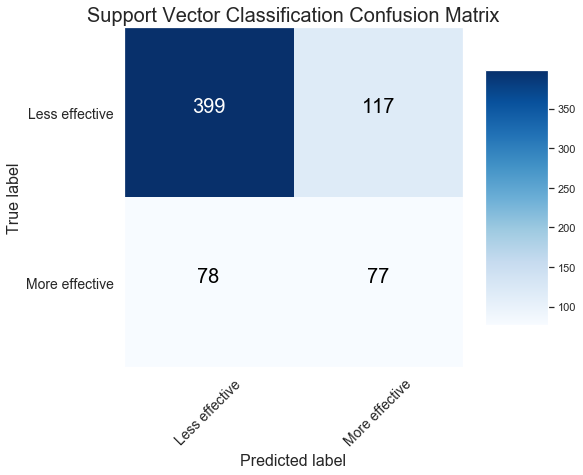

In [21]:
#Show confusion matrix
show_con_matrix(optimised_svc,y_test, X_test,'Support Vector Classification Confusion Matrix')

### Naive Bayes

In [22]:
#set up model
gnb = GaussianNB()

#fit model
gnb.fit(X_train,y_train)
#because there aren't hyperparameters, we can't use our fancy defined function, so we'll pull the results manually
print("Test Accuracy: {}".format(accuracy_score(y_test, gnb.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, gnb.predict(X_test),average='macro')))

nb_train_predictions = gnb.predict(X_train)
nb_test_predictions = gnb.predict(X_test)

nb_train_mse = mean_squared_error(y_train, nb_train_predictions)
nb_test_mse = mean_squared_error(y_test, nb_test_predictions)
    
nb_train_auc = roc_auc_score(y_train, nb_train_predictions)
nb_test_auc = roc_auc_score(y_test, nb_test_predictions)

print("Train MSE: {}".format(nb_train_mse))
print("Test MSE: {}".format(nb_test_mse))
    
print("Train ROC AUC: {}".format(nb_train_auc))
print("Test ROC AUC: {}".format(nb_test_auc))

Test Accuracy: 0.2727272727272727
F1 Score: 0.24658088979697018
Train MSE: 0.7224456958970233
Test MSE: 0.7272727272727273
Train ROC AUC: 0.5347150259067357
Test ROC AUC: 0.5248749687421855


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

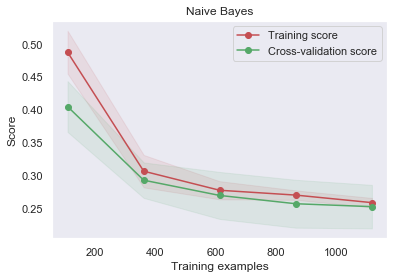

In [23]:
#High is Better
plot_learning_curve(gnb,'Naive Bayes',X_train,y_train,cv=10,n_jobs=-1)

Confusion matrix, without normalization


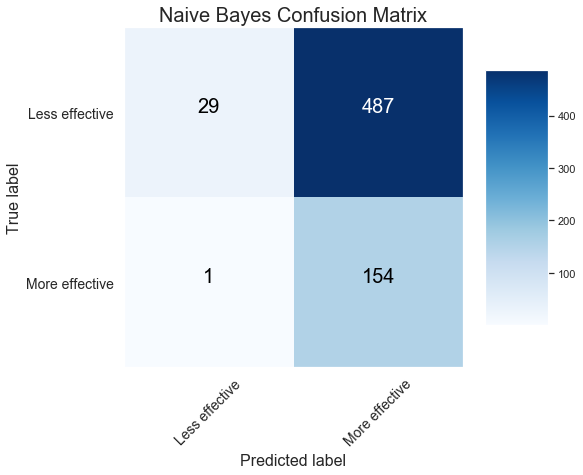

In [24]:
#Show confusion matrix
show_con_matrix(gnb,y_test, X_test,'Naive Bayes Confusion Matrix')

### Stochiastic Gradient Descent

In [25]:
#set up model, allow it to use all cores
sgd = SGDClassifier(n_jobs=-1,class_weight='balanced')

#set hyperparameters
param_grid = {"loss": ['log', 'modified_huber'],
             "l1_ratio" :[0, .001, .04, .5, .69, .8, .9, .99, .999,1],
             "penalty":['none', 'l2', 'l1', 'elasticnet'],
             "early_stopping":[False,True]}

#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
sgd_gridsearch = GridSearchCV(sgd,param_grid=param_grid,scoring=F1_scorer,cv=10)

#fit model
sgd_gridsearch.fit(X_train,y_train)

#save model
optimised_sgd = sgd_gridsearch.best_estimator_
optimised_sgd

C:\Users\zgeorge\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.99, learning_rate='optimal', loss='modified_huber',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='none', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
#see how it did
show_me_the_money(optimised_sgd,y_test,X_test)

Test Accuracy: 0.6184798807749627
F1 Score: 0.5608908157631035
Train MSE: 0.3563958165728077
Test MSE: 0.38152011922503726
Train ROC AUC: 0.6437041040742536
Test ROC AUC: 0.5962178044511127


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

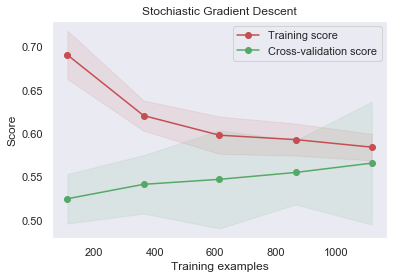

In [27]:
#High is Better
plot_learning_curve(optimised_sgd,'Stochiastic Gradient Descent',X_train,y_train,cv=10,n_jobs=-1)

Confusion matrix, without normalization


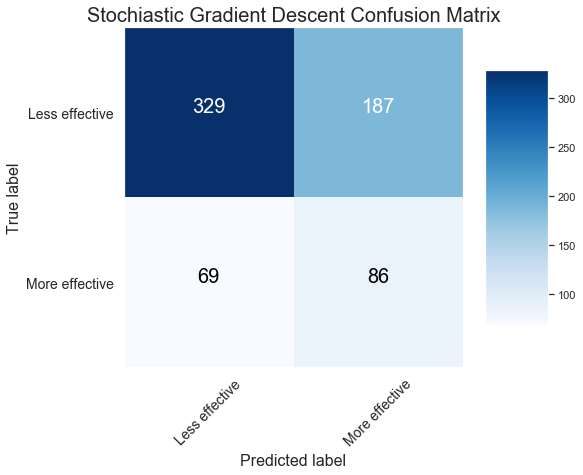

In [28]:
#Show confusion matrix
show_con_matrix(optimised_sgd,y_test, X_test,'Stochiastic Gradient Descent Confusion Matrix')

### K-Nearest Neighbors

In [29]:
#set up model, allow it to use all cores
knk = KNeighborsClassifier(n_jobs = -1)

#set hyperparameters
param_grid = {"n_neighbors": [2,3,4, 5, 7,9,13],
             "weights": ['uniform','distance'],
              "p": [1,2,3]}

#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
knk_gridsearch = GridSearchCV(knk,param_grid=param_grid,scoring=F1_scorer,cv=5)

#fit model
knk_gridsearch.fit(X_train,y_train)

#save model
optimised_knk = knk_gridsearch.best_estimator_
optimised_knk

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=7, p=1,
           weights='uniform')

In [30]:
#see how it did
show_me_the_money(optimised_knk,y_test,X_test)

Test Accuracy: 0.7526080476900149
F1 Score: 0.5552245719396882
Train MSE: 0.16733708769107
Test MSE: 0.2473919523099851
Train ROC AUC: 0.6719946322734559
Test ROC AUC: 0.5547886971742935


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

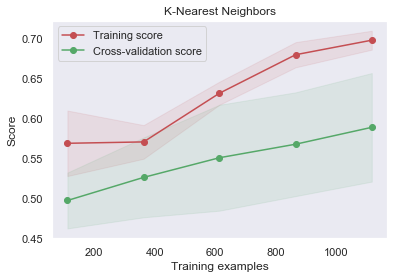

In [31]:
#High is Better
plot_learning_curve(optimised_knk,'K-Nearest Neighbors',X_train,y_train,cv=10,n_jobs=-1)

*For high variance:*

- Get more training data
- Try a smaller set of features
- Try a less complex model
- Add regularization - Prevents it from fitting

Confusion matrix, without normalization


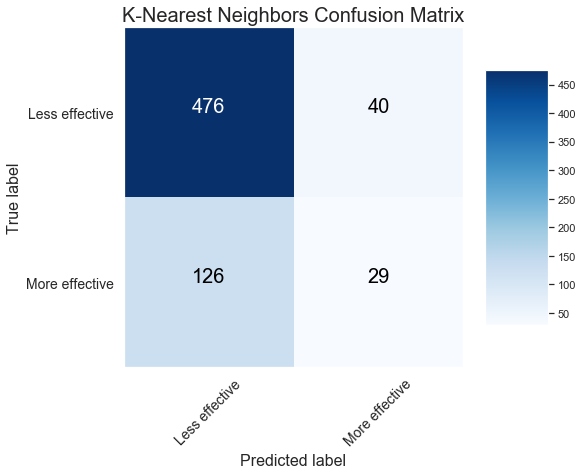

In [32]:
#Show confusion matrix
show_con_matrix(optimised_knk,y_test, X_test,'K-Nearest Neighbors Confusion Matrix')

### Random Forrest Classifiers

In [33]:
#set up model, allow it to use all cores
rfc = RandomForestClassifier(random_state=42, n_jobs = -1)

#set hyperparameters
param_grid = {"n_estimators": [ 105, 110, 115, 120],
             "min_samples_leaf":[1,2,3,4],
             "class_weight":["balanced", "balanced_subsample"]}


#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
rfc_gridsearch = GridSearchCV(rfc,param_grid=param_grid,scoring=F1_scorer,cv=5)

#fit model
rfc_gridsearch.fit(X_train,y_train)

#save model
optimised_rfc = rfc_gridsearch.best_estimator_

In [34]:
#see how it did
show_me_the_money(optimised_rfc,y_test,X_test)

Test Accuracy: 0.8584202682563339
F1 Score: 0.8011951060531872
Train MSE: 0.04585679806918745
Test MSE: 0.14157973174366617
Train ROC AUC: 0.9640641890632572
Test ROC AUC: 0.8018754688672168


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

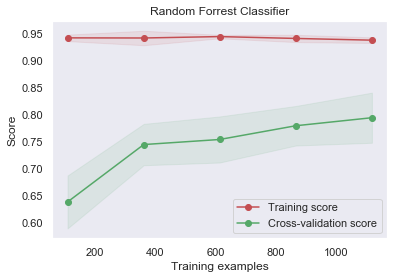

In [35]:
#High is Better
plot_learning_curve(optimised_rfc,'Random Forrest Classifier',X_train,y_train,cv=10,n_jobs=-1)

*For high variance:*

- Get more training data
- Try a smaller set of features
- Try a less complex model
- Add regularization - Prevents it from fitting

Confusion matrix, without normalization


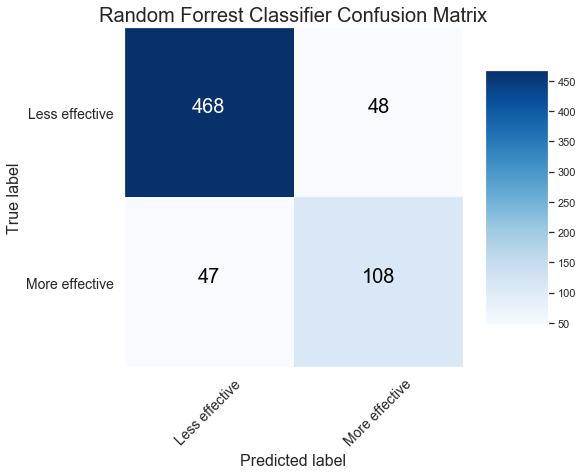

In [36]:
#Show confusion matrix
show_con_matrix(optimised_rfc,y_test, X_test,'Random Forrest Classifier Confusion Matrix')

In [37]:
#Retrieve feature importances and insert them into a dataframe
imp_feat_rfc = sorted(list(zip(train_x.columns, optimised_rfc.feature_importances_)), key=lambda x: x[1], reverse=True)

Text(0.5, 1.0, 'Feature Importances')

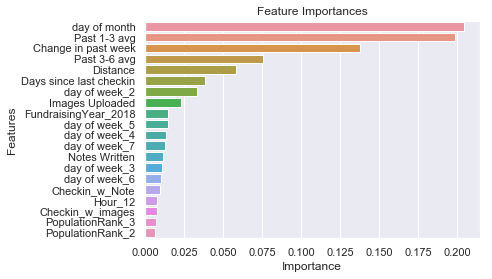

In [40]:
#Create a plot of the top ten importances
importance_rfc = pd.DataFrame(imp_feat_rfc,columns=['Features','Importance'])
sns.barplot('Importance','Features',data=importance_rfc.head(20))
plt.title('Feature Importances')

### Deep Learning

In [41]:
#set up model, allow it to use all cores
dl = MLPClassifier(random_state=1,early_stopping=True)

#set hyperparameters
param_grid = {"solver": ['lbfgs', 'sgd', 'adam'],
             "alpha": [1e-5,1e-4,1e-3,1e-2,1,10]}


#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
dl_gridsearch = GridSearchCV(dl,param_grid=param_grid,scoring=F1_scorer,cv=5)

#fit model
dl_gridsearch.fit(X_train,y_train)

#save model
optimised_dl = dl_gridsearch.best_estimator_

In [42]:
#see how it did
show_me_the_money(optimised_dl,y_test,X_test)

Test Accuracy: 0.7690014903129657
F1 Score: 0.6225096817982193
Train MSE: 0.03700724054706356
Test MSE: 0.23099850968703428
Train ROC AUC: 0.9262291721027324
Test ROC AUC: 0.6105838959739935


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

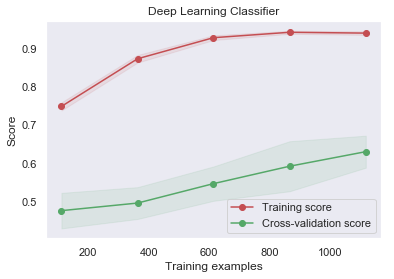

In [43]:
#High is Better
plot_learning_curve(optimised_dl,'Deep Learning Classifier',X_train,y_train,cv=10,n_jobs=-1)

*For high variance:*

- Get more training data
- Try a smaller set of features
- Try a less complex model
- Add regularization - Prevents it from fitting

Confusion matrix, without normalization


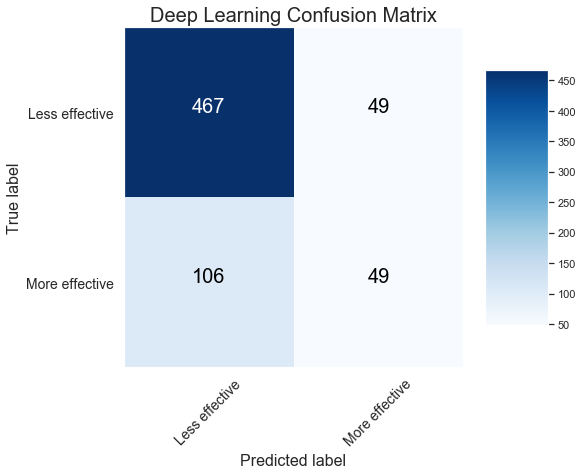

In [44]:
#Show confusion matrix
show_con_matrix(optimised_dl,y_test, X_test,'Deep Learning Confusion Matrix')

## Gradient Boosting

In [45]:
#set up model, allow it to use all cores
gbc = GradientBoostingClassifier()

#set hyperparameters
param_grid = {"learning_rate": [.00001,.0001,.001,.01],
             "n_estimators": [50,100,150,200],
             "max_features":['auto','log2',None]}


#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
gbc_gridsearch = GridSearchCV(gbc,param_grid=param_grid,scoring=F1_scorer,cv=5)

#fit model
gbc_gridsearch.fit(X_train,y_train)

#save model
optimised_gbc = gbc_gridsearch.best_estimator_
optimised_gbc

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [46]:
#see how it did
show_me_the_money(optimised_gbc,y_test,X_test)

Test Accuracy: 0.8763040238450075
F1 Score: 0.803743784732378
Train MSE: 0.1246983105390185
Test MSE: 0.12369597615499255
Train ROC AUC: 0.7609162411003839
Test ROC AUC: 0.772880720180045


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

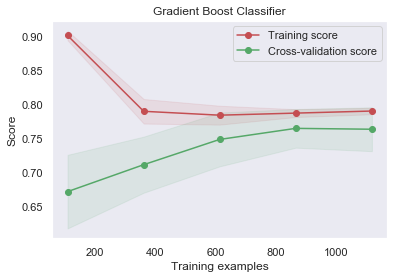

In [47]:
#High is Better
plot_learning_curve(optimised_gbc,'Gradient Boost Classifier',X_train,y_train,cv=10,n_jobs=-1)

Confusion matrix, without normalization


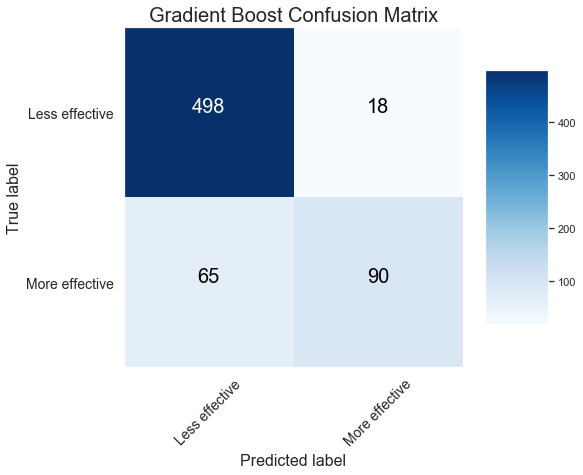

In [48]:
#Show confusion matrix
show_con_matrix(optimised_gbc,y_test, X_test,'Gradient Boost Confusion Matrix')

In [49]:
#Retrieve feature importances and insert them into a dataframe
imp_feat_gbc = sorted(list(zip(train_x.columns, optimised_gbc.feature_importances_)), key=lambda x: x[1], reverse=True)

Text(0.5, 1.0, 'Feature Importances')

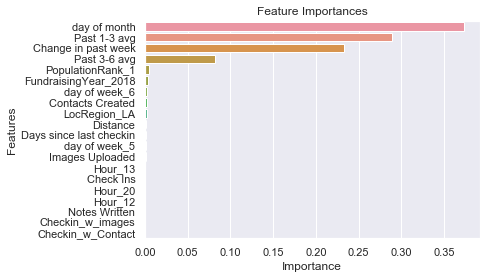

In [50]:
#Create a plot of the top ten importances
importance_gbc = pd.DataFrame(imp_feat_gbc,columns=['Features','Importance'])
sns.barplot('Importance','Features',data=importance_gbc.head(20))
plt.title('Feature Importances')